In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.signal import convolve, correlate, correlate2d
from sklearn.model_selection import train_test_split

In [ ]:
# 1. 합성곱(convolution) 연산

# 1차원 배열
w = np.array([2, 1, 5, 3])
x = np.array([2, 8, 3, 7, 1, 2, 0, 4, 5])

In [ ]:
# 배열 뒤집기

# 방법 1.
w_r = np.flip(w)
print(w_r)

[3 5 1 2]


In [ ]:
# 방법 2.
w_r = w[::-1]
print(w_r)

[3 5 1 2]


In [ ]:
#  합성곱 수행하기

# 방법 1.
for i in range(6):
  print(np.dot(x[i:i+4], w_r))

63
48
49
28
21
20


In [ ]:
# 방법 2.
convolve(x, w, mode='valid')

array([63, 48, 49, 28, 21, 20])

In [ ]:
# 2. 교차 상관(cross-correlation) 연산 - 미끄러지는 배열을 뒤집지 않는다.

# 밸리드 패딩 - 원본 배열의 각 원소의 합성곱 연산 참여도가 다르다.
correlate(x, w, mode='valid')

array([48, 57, 24, 25, 16, 39])

In [ ]:
# 풀 패딩    - 원본 배열의 각 원소의 합성곱 연산 참여도가 동일.
correlate(x, w, mode='full')

array([ 6, 34, 51, 48, 57, 24, 25, 16, 39, 29, 13, 10])

In [ ]:
# 세임 패딩 - 원본 배열의 길이 = 출력 배열의 길이 / 주로 사용 
correlate(x, w, mode='same')

array([34, 51, 48, 57, 24, 25, 16, 39, 29])

In [ ]:
# 2차원 배열
x = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
w = np.array([[2, 0],
              [0, 0]])

correlate2d(x, w, mode='valid')

array([[ 2,  4],
       [ 8, 10]])

In [ ]:
correlate2d(x, w, mode='same')

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

In [ ]:
# 텐서플로를 이용한 합성곱 연산

# 2차원 배열 -> 4차원 배열 
x_4d = x.astype(np.float).reshape(1, 3, 3, 1) # 입력(배치, 높이, 너비, 컬러 채널) - 텐서플로는 실수형의 입력
w_4d = w.reshape(2, 2, 1, 1) # 가중치(높이, 너비, 채널, 가중치 개수)

c_out = tf.nn.conv2d(x_4d, w_4d, strides=1, padding='SAME')
c_out.numpy().reshape(3, 3)

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

In [ ]:
# 최대 풀링

x = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8],
              [9, 10, 11, 12],
              [13, 14, 15, 16]])
x = x.reshape(1, 4, 4, 1)

p_out = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='VALID') # cf. 평균 풀링 avg_pool2d()
p_out.numpy().reshape(2, 2)

array([[ 6.,  8.],
       [14., 16.]], dtype=float32)

In [ ]:
# 렐루 함수

def relu(x):
  return np.maximum(x, 0)

x = np.array([-1, 2, -3, 4, -5])
relu(x)

array([0, 2, 0, 4, 0])

In [ ]:
r_out = tf.nn.relu(x)
r_out.numpy()

array([0, 2, 0, 4, 0])

In [ ]:
class ConvolutionNetwork:
  
  def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
    self.n_kernels = n_kernels # 커널 개수 - 합성곱
    self.kernel_size = 3 
    self.optimizer = None
    self.conv_w = None         # 가중치    - 합성곱층
    self.conv_b = None         # 절편      - 합성곱층
    self.units = units         # 뉴런 개수 - 은닉층
    self.batch_size = batch_size
    self.w1 = None             # 가중치    - 은닉층
    self.b1 = None             # 절편      - 은닉층
    self.w2 = None             # 가중치    - 출력층
    self.b2 = None             # 절편      - 출력층
    self.a1 = None             # 활성화    - 은닉층
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate

  # 정방향 계산
  def forpass(self, x):
    c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b # 합성곱 
    r_out = tf.nn.relu(c_out) # 렐루 함수
    p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID') # 2x2 최대 풀링
    f_out = tf.reshape(p_out, [x.shape[0], -1]) # 첫 번째 배치 자원을 제외하고, 일렬로 펼침
    
    # 완전 연결층
    z1 = tf.matmul(f_out, self.w1) + self.b1 # 첫 번째 층의 선형식 계산
    a1 = tf.nn.relu(z1) # 활성화 함수 적용
    z2 = tf.matmul(a1, self.w2) + self.b2    # 두 번째 층의 선형식 계산
    return z2

  # 가중치 초기화
  def init_weights(self, input_shape, n_classes):
    g = tf.initializers.glorot_uniform()
    self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
    self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
    n_features = 14 * 14 * self.n_kernels
    self.w1 =  tf.Variable(g((n_features, self.units)))
    self.b1 = tf.Variable(np.zeros(self.units), dtype=float)
    self.w2 =  tf.Variable(g((self.units, n_classes)))
    self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    self.init_weights(x.shape, y.shape[1])
    self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
    
    for i in range(epochs):
      print('에포크', i, end=' ')
      batch_losses = []
      for x_batch, y_batch in self.gen_batch(x, y):
        print('.', end='') 
        self.training(x_batch, y_batch)
        batch_losses.append(self.get_loss(x_batch, y_batch))
      print()
      self.losses.append(np.mean(batch_losses))
      self.val_losses.append(self.get_loss(x_val, y_val))

  # 미니 배치 제너레이터 함수
  def gen_batch(self, x, y):
    bins = len(x) // self.batch_size # 미니 배치 횟수
    indexes = np.random.permutation(np.arange(len(x))) # 인덱스 섞기
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]

  # 역방향 계산
  def training(self, x, y):
    m = len(x)

    # 자동 미분 기능
    with tf.GradientTape() as tape: 
      z = self.forpass(x)
      loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
      loss = tf.reduce_mean(loss)

    weights_list = [self.conv_w, self.conv_b, self.w1, self.b1, self.w2, self.b2]
    grads = tape.gradient(loss, weights_list)
    self.optimizer.apply_gradients(zip(grads, weights_list)) # 가중치 업데이트

  def predict(self, x):
    z = self.forpass(x)
    return np.argmax(z.numpy(), axis=1) # 가장 큰 값의 인덱스 반환

  def score(self, x, y):
    return np.mean(self.predict(x) == np.argmax(y, axis=1))
  
  def get_loss(self, x, y):
    z = self.forpass(x)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
    return loss.numpy()

In [ ]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42) 

# 원-핫 인코딩으로 변환
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

# 입력 데이터
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [ ]:
x_train.shape

(48000, 28, 28, 1)

In [ ]:
x_train = x_train / 255
x_val = x_val / 255

In [ ]:
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=20)

에포크 0 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2 ......................................................................................................................................................................................................................................

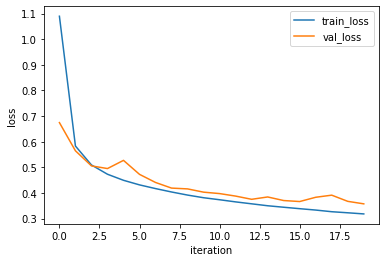

In [ ]:
plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
cn.score(x_val, y_val_encoded) 

0.8773333333333333

In [ ]:
# 케라스로 합성곱 신경망 구현

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

In [ ]:
conv1 = tf.keras.Sequential()
conv1.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1))) # 합성곱층
conv1.add(MaxPooling2D((2, 2))) # 풀링층
conv1.add(Flatten()) # 완전 연결층에 주입할 수 있도록 특성맵을 일렬로 펼치기
conv1.add(Dropout(0.5))
conv1.add(Dense(100, activation='relu')) # 완전 연결층
conv1.add(Dense(10, activation='softmax')) # 완전 연결층

conv1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1960)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
________________________________________________

In [ ]:
conv1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = conv1.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 22s 15ms/step - loss: 0.6939 - accuracy: 0.7528 - val_loss: 0.3504 - val_accuracy: 0.8740
Epoch 2/20
1500/1500 [==============================] - 21s 14ms/step - loss: 0.3925 - accuracy: 0.8539 - val_loss: 0.3236 - val_accuracy: 0.8819
Epoch 3/20
1500/1500 [==============================] - 22s 14ms/step - loss: 0.3451 - accuracy: 0.8721 - val_loss: 0.2898 - val_accuracy: 0.8966
Epoch 4/20
1500/1500 [==============================] - 22s 14ms/step - loss: 0.3076 - accuracy: 0.8869 - val_loss: 0.2685 - val_accuracy: 0.9043
Epoch 5/20
1500/1500 [==============================] - 22s 14ms/step - loss: 0.2908 - accuracy: 0.8925 - val_loss: 0.2588 - val_accuracy: 0.9062
Epoch 6/20
1500/1500 [==============================] - 21s 14ms/step - loss: 0.2753 - accuracy: 0.8978 - val_loss: 0.2497 - val_accuracy: 0.9107
Epoch 7/20
1500/1500 [==============================] - 22s 15ms/step - loss: 0.2635 - accuracy: 0.8986 - val_loss: 0.2521 -

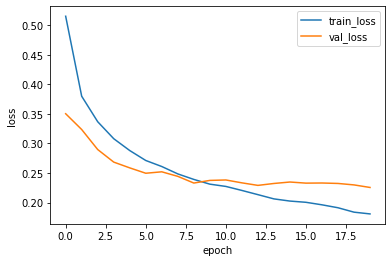

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

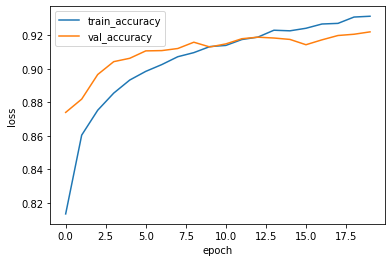

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()